# <center>Stroke prediction</center>
## Getting to know the data
You can download the dataset [here](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import optuna

from imblearn.under_sampling import RandomUnderSampler
from sklearn import tree
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, cross_val_predict

In [2]:
sns.set_style('darkgrid')
plt.style.use('dark_background')
plt.rcParams.update({"grid.linewidth": 0.5, "grid.alpha": 0.5})
pio.renderers.default = 'notebook+jupyterlab+pdf'

In [3]:
data = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
data.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

**Attribute Information**
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke(**target feature**): 1 if the patient had a stroke or 0 if not 

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
data.describe()

id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000    33.100000     0.000000  
max           271.740000    97.600000     1.000000

In [6]:
data.describe(include='object')

gender ever_married work_type Residence_type smoking_status
count     5110         5110      5110           5110           5110
unique       3            2         5              2              4
top     Female          Yes   Private          Urban   never smoked
freq      2994         3353      2925           2596           1892

In [7]:
data.isnull().sum().reset_index().rename(columns={'index': 'feature', 0: 'nulls'})

feature  nulls
0                  id      0
1              gender      0
2                 age      0
3        hypertension      0
4       heart_disease      0
5        ever_married      0
6           work_type      0
7      Residence_type      0
8   avg_glucose_level      0
9                 bmi    201
10     smoking_status      0
11             stroke      0

In [8]:
print("Total duplicates(without 'id' column):", data.drop(columns='id').duplicated().sum())

Total duplicates(without 'id' column): 0


In [9]:
data['stroke'].value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

## Data cleaning

In [10]:
data.drop(columns='id', inplace=True)

Fill *bmi* by median of each class of *stroke*

In [11]:
have_stroke_mask = data['stroke'] == 1
fill_value_have_stroke = data[have_stroke_mask]['bmi'].median()
fill_value_havent_stroke = data[~have_stroke_mask]['bmi'].median()
data.loc[have_stroke_mask, 'bmi'] = data.loc[have_stroke_mask, 'bmi'].fillna(value=fill_value_have_stroke)
data.loc[~have_stroke_mask, 'bmi'] = data.loc[~have_stroke_mask, 'bmi'].fillna(value=fill_value_havent_stroke)
data.isnull().sum().reset_index().rename(columns={'index': 'feature', 0: 'nulls'})

feature  nulls
0              gender      0
1                 age      0
2        hypertension      0
3       heart_disease      0
4        ever_married      0
5           work_type      0
6      Residence_type      0
7   avg_glucose_level      0
8                 bmi      0
9      smoking_status      0
10             stroke      0

## Data visualisation

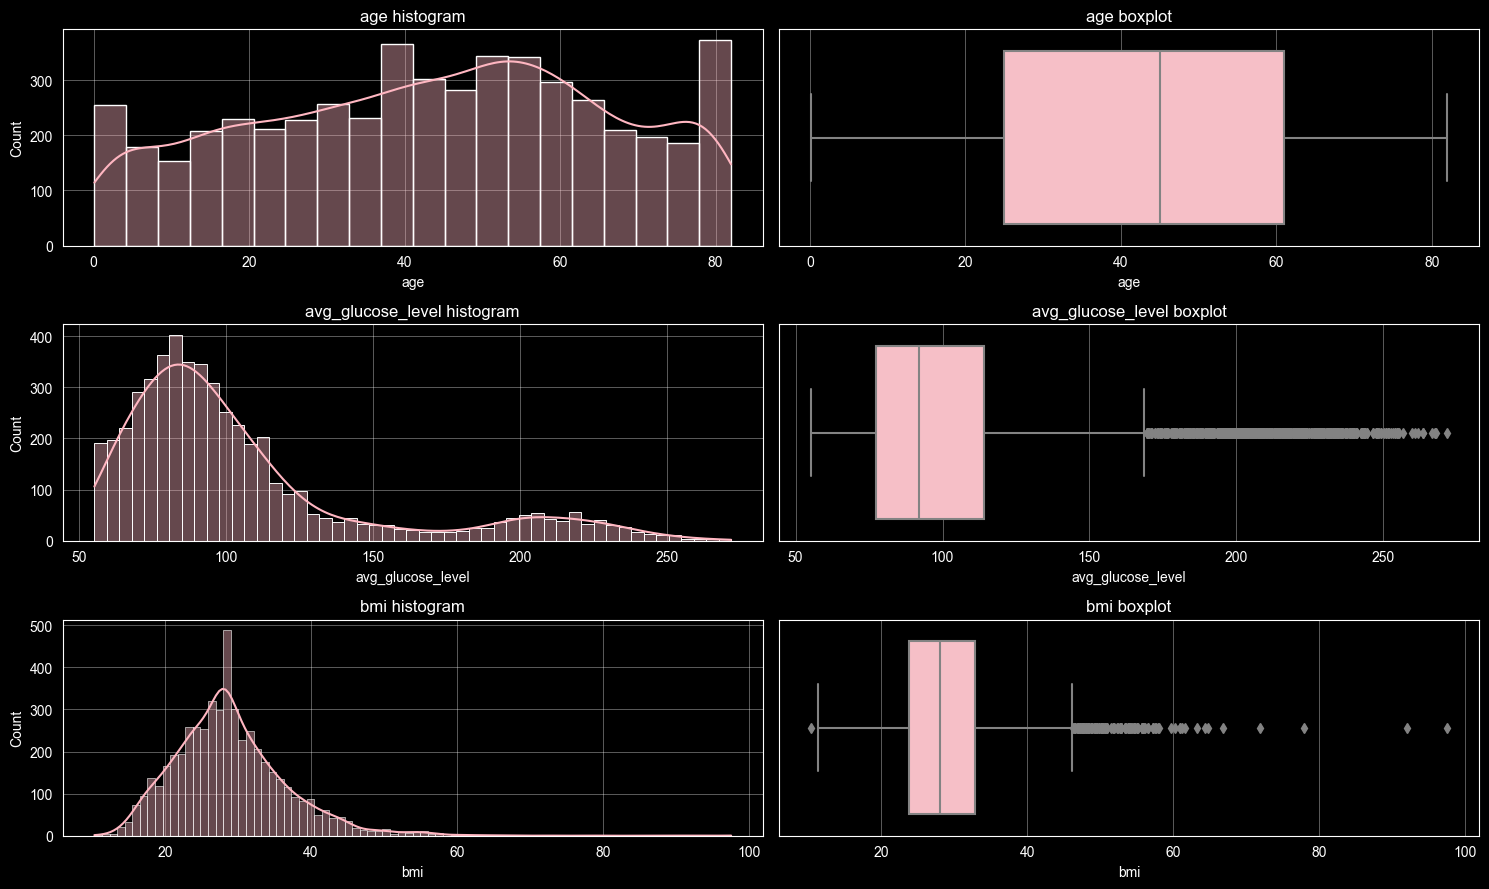

In [12]:
def make_histbox(data, features:list):
    fig, axs = plt.subplots(len(features), 2, figsize=(15, 9))
    for feature, row in zip(features, range(len(features))):
        ax1, ax2 = axs[row, 0], axs[row, 1]
        sns.histplot(data, x=feature, ax=ax1, kde=True, color='lightpink', alpha=0.4)
        sns.boxplot(data, x=feature, ax=ax2, color='lightpink')
        ax1.set_title(feature + ' histogram')
        ax2.set_title(feature + ' boxplot')
    fig.tight_layout()
    
num_cols = ['age', 'avg_glucose_level', 'bmi']
make_histbox(data, num_cols)

In [13]:
px.pie(
    data,
    names='stroke',
    facet_col='heart_disease',
    template='plotly_dark',
    title='The link between stroke and heart disease',
    height=500,
    width=800,
    hole=0.4,
    opacity=0.8
)

In [14]:
px.pie(
    data,
    names='heart_disease',
    facet_col='smoking_status',
    template='plotly_dark',
    title='The link between heart disease and smoking status',
    height=500,
    width=1200,
    hole=0.4,
    opacity=0.8
)

In [15]:
px.histogram(
    data,
    x='work_type',
    color='gender',
    barmode='group',
    template='plotly_dark',
    width=900,
    height=500,
    title='The dependence of the work type on gender',
    opacity=0.8
)

## EDA

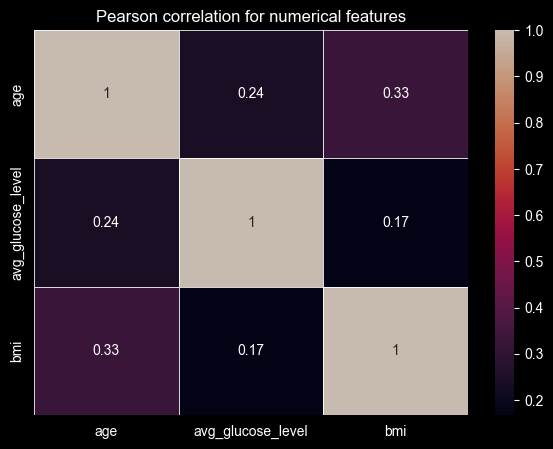

In [16]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(
    data[num_cols].corr(),
    ax=ax,
    annot=True,
    alpha=0.8,
    linewidths=0.5
)
ax.set_title('Pearson correlation for numerical features');

In [17]:
data['gender'] = data['gender'].apply(lambda gender: int('Male' in gender))
data['ever_married'] = data['ever_married'].apply(lambda married: int('Yes' in married))
data['Residence_type'] = data['Residence_type'].apply(lambda residence: int('Urban' in residence))

data = pd.get_dummies(data)
data.head()

gender   age  hypertension  heart_disease  ever_married  Residence_type  \
0       1  67.0             0              1             1               1   
1       0  61.0             0              0             1               0   
2       1  80.0             0              1             1               0   
3       0  49.0             0              0             1               1   
4       0  79.0             1              0             1               0   

   avg_glucose_level   bmi  stroke  work_type_Govt_job  \
0             228.69  36.6       1                   0   
1             202.21  29.7       1                   0   
2             105.92  32.5       1                   0   
3             171.23  34.4       1                   0   
4             174.12  24.0       1                   0   

   work_type_Never_worked  work_type_Private  work_type_Self-employed  \
0                       0                  1                        0   
1                       0                  0                        1   
2                       0                  1                        0   
3                       0                  1                        0   
4                       0                  0                        1   

   work_type_children  smoking_status_Unknown  smoking_status_formerly smoked  \
0                   0                       0                               1   
1                   0                       0                               0   
2                   0                       0                               0   
3                   0                       0                               0   
4                   0                       0                               0   

   smoking_status_never smoked  smoking_status_smokes  
0                            0                      0  
1                            1                      0  
2                            1                      0  
3                            0                      1  
4                            1                      0

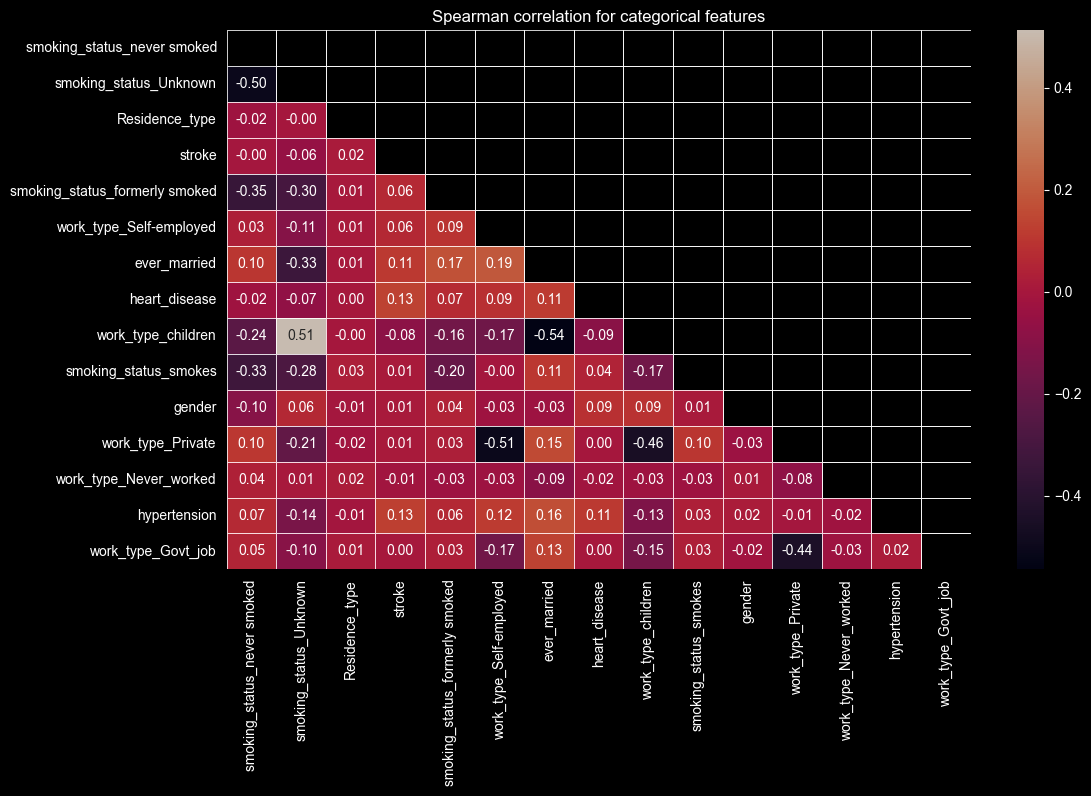

In [18]:
cat_cols = list(set(data.columns).difference(num_cols))

mask = np.triu(data[cat_cols].corr(method='spearman'))
fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(
    data[cat_cols].corr(method='spearman'),
    annot=True,
    ax=ax,
    fmt='.2f',
    alpha=0.8,
    mask=mask,
    linewidths=0.5
)
ax.set_title('Spearman correlation for categorical features');

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          5110 non-null   int64  
 1   age                             5110 non-null   float64
 2   hypertension                    5110 non-null   int64  
 3   heart_disease                   5110 non-null   int64  
 4   ever_married                    5110 non-null   int64  
 5   Residence_type                  5110 non-null   int64  
 6   avg_glucose_level               5110 non-null   float64
 7   bmi                             5110 non-null   float64
 8   stroke                          5110 non-null   int64  
 9   work_type_Govt_job              5110 non-null   uint8  
 10  work_type_Never_worked          5110 non-null   uint8  
 11  work_type_Private               5110 non-null   uint8  
 12  work_type_Self-employed         51

## Building a machine learning model

In [20]:
X, y = data.drop(columns=['stroke']), data['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3832, 17) (1278, 17) (3832,) (1278,)


### Logistic regression

In [21]:
logreg_model = linear_model.LogisticRegression(random_state=42, class_weight='balanced', max_iter=10000)
logreg_model.fit(X_train, y_train)

y_train_pred = logreg_model.predict(X_train)
y_test_pred = logreg_model.predict(X_test)

print('Train F1-score:', metrics.f1_score(y_train, y_train_pred))
print('Test F1-score:', metrics.f1_score(y_test, y_test_pred))

Train F1-score: 0.2364607170099161
Test F1-score: 0.22121896162528218


### RandomForestClassifier

In [30]:
scv = StratifiedKFold(n_splits=5)

def objective_rf(trial:optuna.Trial, X=X_train, y=y_train):
    params=dict(
        n_estimators=trial.suggest_int('n_estimators', 400, 500),
        max_depth=trial.suggest_int('max_depth', 10, 40),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 15),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 20),
        criterion=trial.suggest_categorical('criterion', ['gini', 'entropy'])
    )
    model = ensemble.RandomForestClassifier(**params, n_jobs=-1, random_state=42, class_weight='balanced')
    score = cross_val_score(model, X, y, cv=scv, scoring='f1', n_jobs=-1).mean()
    return score

study_rf = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
study_rf.optimize(objective_rf, n_trials=20)

best_rf = ensemble.RandomForestClassifier(**study_rf.best_params, n_jobs=-1, random_state=42, class_weight='balanced')
best_rf.fit(X_train, y_train)

y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

print('Best Optuna params:', study_rf.best_params)
print('Train F1-score:', metrics.f1_score(y_train, y_train_pred))
print('Test F1-score:', metrics.f1_score(y_test, y_test_pred))

[I 2023-04-07 00:17:52,208] A new study created in memory with name: RandomForestClassifier
[I 2023-04-07 00:17:57,109] Trial 0 finished with value: 0.19582275961586307 and parameters: {'n_estimators': 418, 'max_depth': 33, 'min_samples_split': 5, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 0 with value: 0.19582275961586307.
[I 2023-04-07 00:18:00,850] Trial 1 finished with value: 0.24596296501703857 and parameters: {'n_estimators': 494, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 20, 'criterion': 'gini'}. Best is trial 1 with value: 0.24596296501703857.
[I 2023-04-07 00:18:04,274] Trial 2 finished with value: 0.2531738533864183 and parameters: {'n_estimators': 494, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 10, 'criterion': 'gini'}. Best is trial 2 with value: 0.2531738533864183.
[I 2023-04-07 00:18:06,822] Trial 3 finished with value: 0.2466141057899732 and parameters: {'n_estimators': 415, 'max_depth': 40, 'min_samples_split': 3,

Best Optuna params: {'n_estimators': 445, 'max_depth': 26, 'min_samples_split': 8, 'min_samples_leaf': 9, 'criterion': 'gini'}
Train F1-score: 0.5185185185185185
Test F1-score: 0.28310502283105027


### GradientBoostingClassifier

In [36]:
def objective_gb(trial:optuna.Trial, X=X_train, y=y_train):
    params=dict(
        learning_rate=trial.suggest_float('learning_rate', 0.01, 1),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 30),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 30),
        max_depth=trial.suggest_int('max_depth', 2, 5)
    )
    model = ensemble.GradientBoostingClassifier(**params, random_state=42)
    score = cross_val_score(model, X, y, cv=scv, scoring='f1', n_jobs=-1, verbose=1).mean()
    return score

study_gb = optuna.create_study(study_name='GradientBoostingClassifier', direction='maximize')
study_gb.optimize(objective_gb, n_trials=20)

best_gb = ensemble.GradientBoostingClassifier(**study_gb.best_params, random_state=42)
best_gb.fit(X_train, y_train)

y_train_pred = best_gb.predict(X_train)
y_test_pred = best_gb.predict(X_test)

print('Best Optuna params:', study_gb.best_params)
print('Train F1-score:', metrics.f1_score(y_train, y_train_pred))
print('Test F1-score:', metrics.f1_score(y_test, y_test_pred))

[I 2023-04-06 18:22:23,634] A new study created in memory with name: GradientBoostingClassifier
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.1s finished
[I 2023-04-06 18:22:29,852] Trial 0 finished with value: 0.21435464036172522 and parameters: {'learning_rate': 0.9740306663439547, 'min_samples_split': 24, 'min_samples_leaf': 29, 'max_depth': 3}. Best is trial 0 with value: 0.21435464036172522.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished
[I 2023-04-06 18:22:34,252] Trial 1 finished with value: 0.25869142963573954 and parameters: {'learning_rate': 0.5488678033288251, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_depth': 2}. Best is trial 1 with value: 0.25869142963573954.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   

Best Optuna params: {'learning_rate': 0.8028521424826336, 'min_samples_split': 25, 'min_samples_leaf': 22, 'max_depth': 3}
Train F1-score: 0.630057803468208
Test F1-score: 0.17543859649122806


## Changing threshold

C:\Users\sadeyes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\sadeyes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



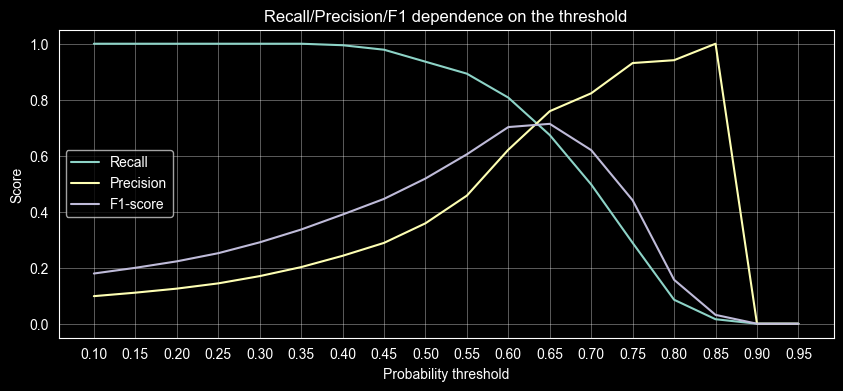

In [31]:
#Считаем вероятности наличия диабета для каждого из пациентов
#Нас интересует только вероятность класса (второй столбец)
y_proba_pred = best_rf.predict_proba(X_train)[:, 1]
#Для удобства завернём numpy-массив в Pandas Series
y_proba_pred = pd.Series(y_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold, относим к классу 1
    #В противном случае — к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_train, y_pred))
    precision_scores.append(metrics.precision_score(y_train, y_pred))
    f1_scores.append(metrics.f1_score(y_train, y_pred))
    
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
 
#Даём графику название и подписываем оси
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

In [32]:
opt_threshold = 0.65
y_train_proba_pred = pd.Series(best_rf.predict_proba(X_train)[:, 1])
y_train_pred_opt = y_train_proba_pred.apply(lambda x: int(x > opt_threshold))
y_test_proba_pred = pd.Series(best_rf.predict_proba(X_test)[:, 1])
y_test_pred_opt = y_test_proba_pred.apply(lambda x: int(x > opt_threshold))

print('Train optimal report:\n', metrics.classification_report(y_train, y_train_pred_opt))
print('Test optimal report:\n', metrics.classification_report(y_test, y_test_pred_opt))

Train optimal report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3645
           1       0.76      0.67      0.71       187

    accuracy                           0.97      3832
   macro avg       0.87      0.83      0.85      3832
weighted avg       0.97      0.97      0.97      3832

Test optimal report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1216
           1       0.29      0.16      0.21        62

    accuracy                           0.94      1278
   macro avg       0.62      0.57      0.59      1278
weighted avg       0.93      0.94      0.93      1278

